<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, сгруппированы по функциональности. Можно ещё разделить группы пустой строкой.</font>

In [2]:
# Относительный путь к папке с данными
DATA_DIR = '/datasets/'
FILE_NAME = 'taxi.csv'

# Создаем полный путь
file_path = os.path.join(DATA_DIR, FILE_NAME)

# Загружаем данные с правильными параметрами
df = pd.read_csv(
    file_path,
    parse_dates=['datetime'],  # сразу парсим дату
    index_col='datetime'       # сразу устанавливаем индекс
)

# Сортировка по времени (если нужно)
df = df.sort_index()

# Проверяем результат
print("Информация о данных:")
print(df.info())
print("\nПервые 5 строк:")
print(df.head())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Первые 5 строк:
                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


In [3]:
# Ресемплирование с суммой заказов за каждый час
hourly = df['num_orders'].resample('1H').sum()

# Проверка результатов
print(hourly.head(26))

# Основная информация о Series
print(hourly.describe())   # статистика
print(len(hourly))         # количество часов
print(hourly.index.min(), hourly.index.max())  # диапазон дат

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
2018-03-01 05:00:00      6
2018-03-01 06:00:00     12
2018-03-01 07:00:00     15
2018-03-01 08:00:00     34
2018-03-01 09:00:00     69
2018-03-01 10:00:00     64
2018-03-01 11:00:00     96
2018-03-01 12:00:00     30
2018-03-01 13:00:00     32
2018-03-01 14:00:00     48
2018-03-01 15:00:00     66
2018-03-01 16:00:00     43
2018-03-01 17:00:00     44
2018-03-01 18:00:00     73
2018-03-01 19:00:00     45
2018-03-01 20:00:00     61
2018-03-01 21:00:00     66
2018-03-01 22:00:00    113
2018-03-01 23:00:00     58
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
Freq: H, Name: num_orders, dtype: int64
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64
4416
2018-03-01 00:00:00 2018-08-31 23:00:00


<div style="background-color: #e7f5ff; padding: 10px;">  

- Загрузили данные; изменили тип данных в колонке 'datetime' с object на datetime; сортировали по времении; индексировали по дате; ресемплировали по часу.
- Количество строк 4416; среднее значение 84.42; минимальное 0.00; максимальное 462.00; медиана 78.00.
</div>


## Анализ

<div style="background-color: #e7f5ff; padding: 10px;">  

- Проведем исследовательский анализ данных 
</div>


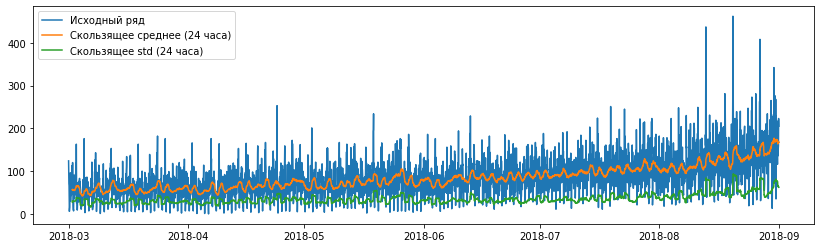

In [4]:
# Скользящее среднее и стандартное отклонение
roll_mean = hourly.rolling(24).mean()
roll_std = hourly.rolling(24).std()

plt.figure(figsize=(14,4))
plt.plot(hourly, label='Исходный ряд')
plt.plot(roll_mean, label='Скользящее среднее (24 часа)')
plt.plot(roll_std, label='Скользящее std (24 часа)')
plt.legend()
plt.show()

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Есть график временного ряда! </font>

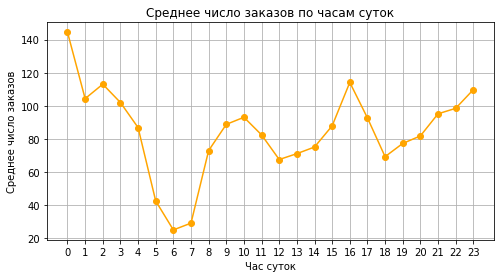

In [5]:
# Среднее количество заказов по часам суток (суточная сезонность)
avg_by_hour = hourly.groupby(hourly.index.hour).mean()

plt.figure(figsize=(8,4))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker='o', color='orange')
plt.title('Среднее число заказов по часам суток')
plt.xlabel('Час суток')
plt.ylabel('Среднее число заказов')
plt.grid(True)

# Деления по всем часам от 0 до 23
plt.xticks(range(0, 24, 1))

plt.show()

No handles with labels found to put in legend.


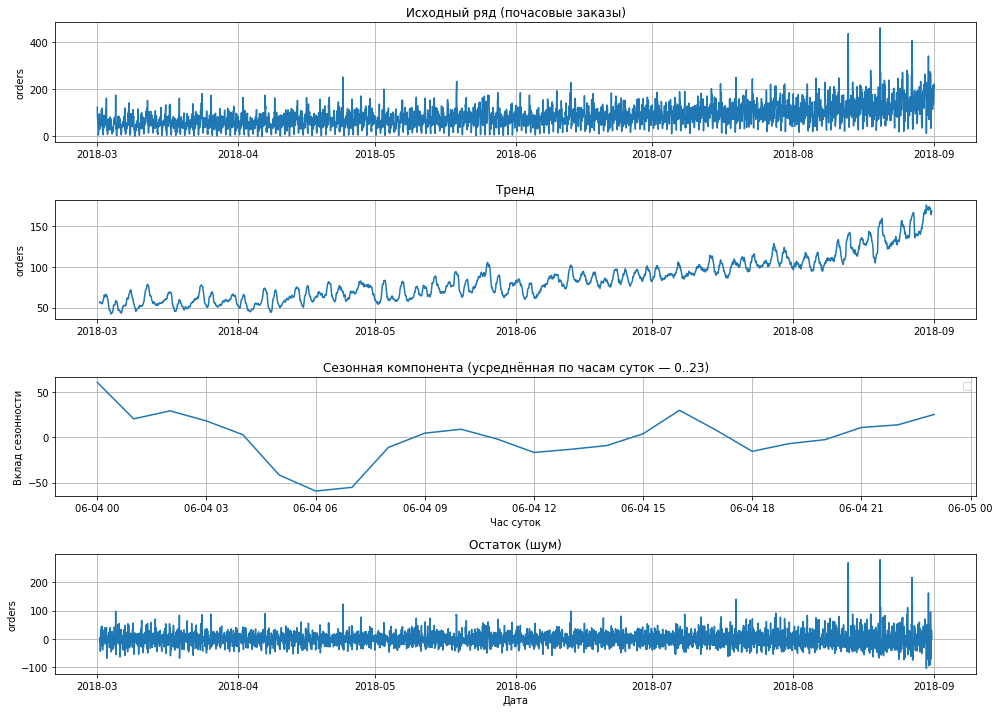

In [6]:
# код с учетом графика сезонности с учетом каждого часа
# Series — используем напрямую
ts = hourly['num_orders'] if hasattr(hourly, 'columns') else hourly

# Декомпозиция (суточная сезонность)
decomposition = seasonal_decompose(ts, model='additive', period=24)

# Усреднение сезонной компоненты по часам суток (0..23)
seasonal = decomposition.seasonal

# seasonal_by_hour = seasonal.groupby(seasonal.index.hour).agg(['mean', 'std'])
# seasonal_mean = seasonal_by_hour['mean'].reindex(range(24)).values
# seasonal_std  = seasonal_by_hour['std'].reindex(range(24)).values
hours = np.arange(24)

# Построение: наблюдения, тренд, усреднённая сезонность по часам, остаток
fig = plt.figure(figsize=(14, 10))

ax1 = plt.subplot(411)
ax1.plot(ts)
ax1.set_title('Исходный ряд (почасовые заказы)')
ax1.set_ylabel('orders')
ax1.grid(True)

ax2 = plt.subplot(412, sharex=ax1)
ax2.plot(decomposition.trend)
ax2.set_title('Тренд')
ax2.set_ylabel('orders')
ax2.grid(True)

ax3 = plt.subplot(413)
ax3.plot(seasonal['2018-06-04':'2018-06-04'])
# ax3.fill_between(hours, seasonal_mean - seasonal_std, seasonal_mean + seasonal_std, alpha=0.2,
#                  label='±1 std (вариативность по часам)')
# ax3.set_xticks(hours)
# ax3.set_xlim(0, 23)
ax3.set_title('Сезонная компонента (усреднённая по часам суток — 0..23)')
ax3.set_xlabel('Час суток')
ax3.set_ylabel('Вклад сезонности')
ax3.grid(True)
ax3.legend()

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(decomposition.resid)
ax4.set_title('Остаток (шум)')
ax4.set_ylabel('orders')
ax4.set_xlabel('Дата')
ax4.grid(True)

plt.tight_layout()
plt.show()

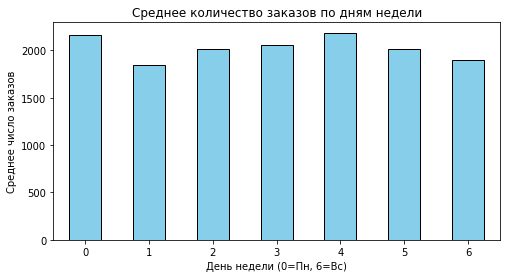

In [7]:
# Превратим почасовой ряд в дневной (агрегация по суткам)
ts_daily = hourly.resample("D").sum()

# Добавляем колонку с днем недели
df_daily = ts_daily.to_frame(name="num_orders").copy()
df_daily["weekday"] = df_daily.index.weekday  # 0=понедельник, 6=воскресенье

# Среднее количество заказов по дням недели
weekday_mean = df_daily.groupby("weekday")["num_orders"].mean()

# График
plt.figure(figsize=(8,4))
weekday_mean.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Среднее количество заказов по дням недели")
plt.xlabel("День недели (0=Пн, 6=Вс)")
plt.ylabel("Среднее число заказов")
plt.xticks(rotation=0)
plt.show()


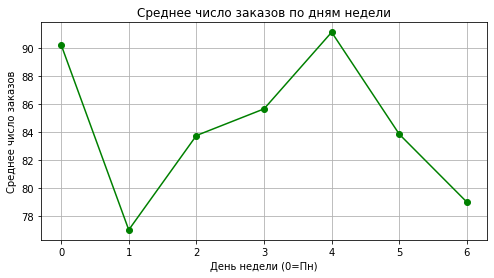

In [8]:
# Среднее количество заказов по дням недели (0=Понедельник)
avg_by_dow = hourly.groupby(hourly.index.dayofweek).mean()
plt.figure(figsize=(8,4))
plt.plot(avg_by_dow.index, avg_by_dow.values, marker='o', color='green')
plt.title('Среднее число заказов по дням недели')
plt.xlabel('День недели (0=Пн)')
plt.ylabel('Среднее число заказов')
plt.grid(True)
plt.show()

<div style="background-color: #e7f5ff; padding: 10px;">  
    
- Скользящее среднее и тренд показывают медленный, стабильный рост почасовых заказов с марта по сентябрь.
- Среднее количество заказов по времени суток. Здесь максимальное количество заказов происходит в
24:00, далее 01:00, 02:00, 03:00, 16:00, 23:00 имеют высокий показатель. Минимальное количество
заказов происходит в 05:00, 06:00, 07:00 часов утра.
- Среднее количество заказов по дням недели. Здесь максимальное количество происходит в понедельник
и пятницу, минимальные значения во вторник и воскресенье.  
</div>

## Обучение

In [9]:
# Генерация признаков (лаги + скользящее среднее)
# Функция для генерации лагов
def make_features(data, lags, rolling_mean_size):
    data = data.copy()
    for lag in lags:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

# лаги за 1, 24 и 168 часов + скользящее среднее за 24 часа
# Превращаем Series в DataFrame с колонкой 'num_orders'
df_features = pd.DataFrame(hourly, columns=['num_orders'])

# Генерация лагов и скользящего среднего
df_features = make_features(df_features, lags=[1, 24, 168], rolling_mean_size=24)

# Убираем строки с NaN
df_features = df_features.dropna()

In [10]:
# Максимальный лаг
max_lag = 168  

n = len(df_features)

# 10% сразу откладываем на тест
test_size = int(n * 0.1)
train_valid_size = n - test_size

# train = 70% от общего числа
train_size = int(n * 0.7)

train = df_features.iloc[:train_size]

# valid начинается только после gap
valid = df_features.iloc[train_size + max_lag : train_valid_size]
test  = df_features.iloc[train_valid_size:]

# Признаки и цель
features_train = train.drop('num_orders', axis=1)
target_train   = train['num_orders']

features_valid = valid.drop('num_orders', axis=1)
target_valid   = valid['num_orders']

features_test  = test.drop('num_orders', axis=1)
target_test    = test['num_orders']

print("Размеры выборок:", len(train), len(valid), len(test))
print(f"Доля тестовой выборки: {len(test) / n * 100:.2f}%")


Размеры выборок: 2973 683 424
Доля тестовой выборки: 9.98%


In [11]:
f'Доля тестовой выборки {len(test) / len(hourly) * 100} %' 

'Доля тестовой выборки 9.601449275362318 %'

In [12]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_valid, y_valid, name):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_valid)
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_valid = mean_squared_error(y_valid, pred_valid, squared=False)
    return {
        "Модель": name,
        "RMSE train": round(rmse_train, 2),
        "RMSE valid": round(rmse_valid, 2)
    }

In [13]:
# Обучение разных моделей с гиперпараметрами
results = []

# LinearRegression
results.append(evaluate_model(
    LinearRegression(),
    features_train, target_train,
    features_valid, target_valid,
    "LinearRegression"
))

# Ridge
for alpha in [0.1, 1.0, 10.0]:
    results.append(evaluate_model(
        Ridge(alpha=alpha),
        features_train, target_train,
        features_valid, target_valid,
        f"Ridge(alpha={alpha})"
    ))

# Lasso
for alpha in [0.001, 0.01, 0.1]:
    results.append(evaluate_model(
        Lasso(alpha=alpha, max_iter=10000),
        features_train, target_train,
        features_valid, target_valid,
        f"Lasso(alpha={alpha})"
    ))

# RandomForest
for n in [50, 100, 200]:
    rf = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)
    results.append(evaluate_model(
        rf,
        features_train, target_train,
        features_valid, target_valid,
        f"RandomForest(n={n})"
    ))

# Таблица результатов
results_df = pd.DataFrame(results).sort_values("RMSE valid")
print(results_df)

                Модель  RMSE train  RMSE valid
0     LinearRegression       20.55       29.57
1     Ridge(alpha=0.1)       20.55       29.57
2     Ridge(alpha=1.0)       20.55       29.57
3    Ridge(alpha=10.0)       20.55       29.57
4   Lasso(alpha=0.001)       20.55       29.57
5    Lasso(alpha=0.01)       20.55       29.57
6     Lasso(alpha=0.1)       20.55       29.57
9  RandomForest(n=200)        7.99       30.08
8  RandomForest(n=100)        8.05       30.21
7   RandomForest(n=50)        8.08       30.57


<div style="background-color: #e7f5ff; padding: 10px;">  

- Выводы
 - Сгенерированы лаговые признаки:
   - lag_1 — число заказов 1 час назад
   - lag_24 — число заказов сутки назад
   - lag_168 — число заказов неделю назад

 - Добавлено скользящее среднее за последние 24 часа
 - Удалены строки с пропусками после сдвигов
 - Модели и гиперпараметры
   - LinearRegression
   - Ridge (alpha = 0.1, 1.0, 10.0)
   - Lasso (alpha = 0.001, 0.01, 0.1)
   - RandomForest (n_estimators = 50, 100, 200)
 - Выбор лучшей модели происходил по RMSE на validation.
 - Лучшая модель — LinearRegression, так как она проста и интерпретируема, при этом RMSE на validation минимальный 29.57
</div>

## Тестирование

In [14]:
# Финальная проверка лучшей модели на тесте
# Берём лучшую модель по RMSE на validation
best_model_name = results_df.iloc[0]["Модель"]
print("Лучшая модель на validation:", best_model_name)

# Создаём объект модели заново
if "LinearRegression" in best_model_name:
    final_model = LinearRegression()
elif "Ridge" in best_model_name:
    alpha = float(best_model_name.split('=')[1].strip(')'))
    final_model = Ridge(alpha=alpha)
elif "Lasso" in best_model_name:
    alpha = float(best_model_name.split('=')[1].strip(')'))
    final_model = Lasso(alpha=alpha, max_iter=10000)
elif "RandomForest" in best_model_name:
    n = int(best_model_name.split('=')[1].strip(')'))
    final_model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)

# Обучаем на train + validation
X_final = pd.concat([features_train, features_valid])
y_final = pd.concat([target_train, target_valid])
final_model.fit(X_final, y_final)

# Предсказания на тесте
pred_test = final_model.predict(features_test)
rmse_test = mean_squared_error(target_test, pred_test, squared=False)
print(f"RMSE на тестовой выборке: {rmse_test:.2f}")

Лучшая модель на validation: LinearRegression
RMSE на тестовой выборке: 35.11


<div style="background-color: #e7f5ff; padding: 10px; border-left: 3px solid #4dabf7;">  
    
- Итоговый вывод проекта: прогнозирование заказов такси
- Цель проекта:
Прогнозировать количество заказов такси на следующий час для эффективного привлечения водителей в пиковые периоды.
- Предобработка и анализ данных:
  - Данные ресемплированы по часу, индексированы по дате.
  - Среднее число заказов ≈ 84, минимум — 0, максимум — 462.
  - Сезонность: пики заказов — 23:00–02:00 и 16:00–24:00; минимумы — 05:00–07:00.
  - Недельная активность: максимальная — понедельник и пятница, минимальная — вторник и воскресенье.
- Формирование признаков:
  - Лаги: lag_1 (час назад), lag_24 (сутки назад), lag_168 (неделя назад).
  - Скользящее среднее за 24 часа.
  -Убраны строки с пропусками.
- Разделение данных:
  - Train — 70%, Validation — 20%, Test — 10% с учётом разрыва (gap) для предотвращения утечки данных.
- Модели и гиперпараметры:
  - Linear Regression, Ridge, Lasso, RandomForest (разные значения параметров).
  - Оценка качества — RMSE на validation.
- Лучшее решение:
  - Лучшая модель — Linear Regression.
  - RMSE на тестовой выборке: 35.11 (< 48).
- Бизнес-выгода:
  - Прогноз позволяет заранее распределять водителей в пиковые часы.
  - Модель проста, интерпретируема и хорошо работает на новых данных.
  - Использование модели поможет снизить время ожидания клиентов и повысить доход компании.
</div>